In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


# By country of citizenship

Define target nationality, check if represented in dataset.

In [3]:
nationality = 'MEXICO'

In [4]:
errormsg = f'{nationality} not represented in dataset'
assert nationality.upper() in df['CountryOfCitizenship'].str.upper().unique(), errormsg

Create DataFrames for removals and transfers, removing duplicate `AlienMasterID` values.

In [5]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')

Ranking total removals by `CountryOfCitizenship`. Should implement other comparative statistics.

In [6]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities.drop('index', axis=1, inplace=True)
target = all_nationalities.loc[all_nationalities['CountryOfCitizenship'] == nationality].reset_index()
print(f"{nationality}: ranked {target.loc[0, 'Rank']} of {len(all_nationalities)} countries, with {target.loc[0, 'AlienMasterID']} total removals.")
# Probably a better way to do this than with index

MEXICO: ranked 1 of 204 countries, with 466108 total removals.


Create a DataFrame filtered for target nationality only.

In [7]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [8]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

El Paso International Airport                     90303
Alexandria International Airport                  57558
Valley International Airport                      57010
Columbus Metropolitan Airport                     49389
Metropolitan Oakland International Airport        32938
Harrisburg International Airport                  28315
Boeing Field King County International Airport    25133
San Diego International Airport                   23543
Meadows Field                                     20494
Miami International Airport                       20043
Name: air_AirportName, dtype: int64

In [9]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

Valley International Airport                            146847
Licenciado Benito Juarez International Airport           85584
El Paso International Airport                            65239
Brownsville South Padre Island International Airport     63458
San Diego International Airport                          59677
Laredo International Airport                             46149
Yuma MCAS/Yuma International Airport                     29060
El Centro Naf Airport                                    20356
Phoenix-Mesa-Gateway Airport                             18186
Alexandria International Airport                         16249
Name: air2_AirportName, dtype: int64

In [10]:
nationality_df.set_index('MissionDate', inplace=True)

In [17]:
nationality_df[nationality_df['R-T'] == 'R']['air2_Country'].value_counts() / len(nationality_df[nationality_df['R-T'] == 'R'])

USA                                 0.816377
Mexico                              0.183614
Honduras                            0.000004
El Salvador                         0.000002
Guatemala                           0.000002
Hungary                             0.000000
Trinidad and Tobago                 0.000000
Serbia                              0.000000
Montenegro                          0.000000
Israel                              0.000000
Republic of the Congo               0.000000
Ethiopia                            0.000000
Cameroon                            0.000000
Democratic Republic of Congo        0.000000
Bermuda                             0.000000
Yemen                               0.000000
China                               0.000000
United Kingdom                      0.000000
Guyana                              0.000000
Guinea                              0.000000
South Sudan                         0.000000
Mali                                0.000000
Niger     

In [11]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])
# g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'Juvenile', 'NonCriminal'])

In [12]:
# We can improve construction of this table, look at other notebooks
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [52]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [53]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [54]:
# Total removals
removals['AlienMasterIDCount'].sum()

580

In [55]:
# Total removal missions
removals['MissionIDCount'].sum()

11

In [56]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

2079

In [57]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [88]:
annual_removals.sum()

580

In [59]:
annual_transfers

MissionDate
2010-10-01     56
2011-10-01     25
2012-10-01    101
2013-10-01    112
2014-10-01    354
2015-10-01    320
2016-10-01    479
2017-10-01    520
2018-10-01    112
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [60]:
annual_juvenile_removals

MissionDate
2011-10-01    False
2012-10-01    False
2013-10-01    False
2014-10-01    False
2015-10-01    False
2016-10-01    False
2017-10-01    False
2018-10-01    False
Freq: AS-OCT, Name: JuvenileCount, dtype: bool

In [61]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [62]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2012-04-15,SOMALIA,R,KAEX,HKJK,9,1,False,0.0,9.0,100.000000
1,2012-11-17,SOMALIA,R,KAEX,HKJK,10,1,False,0.0,1.0,10.000000
2,2014-06-03,SOMALIA,R,KMIA,HKJK,2,1,False,0.0,2.0,100.000000
3,2017-01-24,SOMALIA,R,KAEX,HCMM,90,1,False,0.0,60.0,66.666667
4,2017-03-09,SOMALIA,R,KAEX,HCMM,68,1,False,0.0,56.0,82.352941
5,2017-05-11,SOMALIA,R,KAEX,HCMM,67,1,False,0.0,47.0,70.149254
6,2017-05-25,SOMALIA,R,KIWA,HCMM,50,1,False,0.0,21.0,42.000000
7,2017-07-27,SOMALIA,R,KAEX,HCMM,67,1,False,0.0,19.0,28.358209
8,2018-03-29,SOMALIA,R,KELP,HCMM,68,1,False,0.0,25.0,36.764706
9,2018-06-28,SOMALIA,R,KAEX,HCMM,83,1,False,0.0,28.0,33.734940


In [63]:
removals.to_csv(f'../output/{nationality}_removal_flights.csv')

In [64]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-10-01,SOMALIA,T,KSAN,KIWA,3,1,False,0.0,0.0,0.0
1,2010-10-02,SOMALIA,T,KIWA,KBFI,3,1,False,0.0,0.0,0.0
2,2010-10-15,SOMALIA,T,KONT,KIWA,9,1,False,0.0,0.0,0.0
3,2010-10-16,SOMALIA,T,KIWA,KBFI,9,1,False,0.0,0.0,0.0
4,2010-11-09,SOMALIA,T,KSAN,KIWA,1,1,False,0.0,1.0,100.0


In [65]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [66]:
removals.set_index('MissionDate', inplace=True)

In [67]:
transfers.set_index('MissionDate', inplace=True)

In [68]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

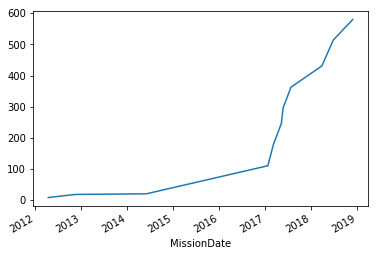

In [69]:
# Cumulative removals
# Based on density of removals, decide whether to use points or line
# r_cum.plot(style='o-')
r_cum.plot(style='-')

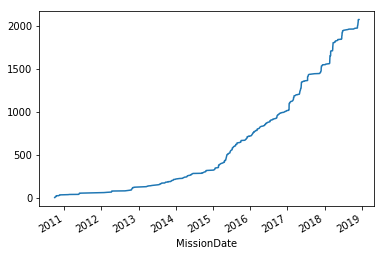

In [70]:
# Cumulative transfers
t_cum.plot()

In [71]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [72]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [73]:
removal_dropoff_airports.head()

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
12,2011-10-01,R,Alexandria International Airport,Jomo Kenyatta International Airport,Kenya,9,1
25,2012-10-01,R,Alexandria International Airport,Jomo Kenyatta International Airport,Kenya,10,1
55,2013-10-01,R,Miami International Airport,Jomo Kenyatta International Airport,Kenya,2,1
154,2016-10-01,R,Alexandria International Airport,Aden Adde International Airport,Somalia,292,4
155,2016-10-01,R,Phoenix-Mesa-Gateway Airport,Aden Adde International Airport,Somalia,50,1


In [74]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
5,2010-10-01,T,Phoenix-Mesa-Gateway Airport,Boeing Field King County International Airport,USA,12,2
11,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,11,3
4,2010-10-01,T,Ontario International Airport,Phoenix-Mesa-Gateway Airport,USA,10,2
7,2010-10-01,T,Phoenix-Mesa-Gateway Airport,Valley International Airport,USA,7,1
0,2010-10-01,T,El Paso International Airport,Phoenix-Mesa-Gateway Airport,USA,4,1
8,2010-10-01,T,Phoenix-Mesa-Gateway Airport,Abilene Regional Airport,USA,4,1
3,2010-10-01,T,Ontario International Airport,George Bush Intercontinental Houston Airport,USA,2,1
6,2010-10-01,T,Phoenix-Mesa-Gateway Airport,McCarran International Airport,USA,2,2
1,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,1,1
2,2010-10-01,T,Meadows Field,San Diego International Airport,USA,1,1


In [75]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [76]:
removal_dropoff_airports = removal_dropoff_airports.set_index('MissionDate')

In [77]:
removal_sum = removal_dropoff_airports.groupby([pd.Grouper(freq='AS-OCT'), 'air2_AirportName'])[['AlienMasterID']].sum()

In [78]:
removal_sum.reset_index(inplace=True)
removal_sum = removal_sum.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False])

In [79]:
removal_sum.set_index('MissionDate', inplace=True)

In [80]:
removal_sum = removal_sum.dropna()

In [86]:
top_5_df = pd.DataFrame()

for year in removal_sum.index.unique():
    temp = removal_sum.loc[f'{year}'][['air2_AirportName', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['air2_AirportName', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

In [87]:
top_5_df

,0,air2_AirportName,AlienMasterID
air2_AirportName,Jomo Kenyatta International Airport,NaN,NaN
AlienMasterID,9,NaN,NaN
2011-10-01 00:00:00,NaN,ALL OTHERS,0.0
air2_AirportName,Jomo Kenyatta International Airport,NaN,NaN
AlienMasterID,10,NaN,NaN
2012-10-01 00:00:00,NaN,ALL OTHERS,0.0
air2_AirportName,Jomo Kenyatta International Airport,NaN,NaN
AlienMasterID,2,NaN,NaN
2013-10-01 00:00:00,NaN,ALL OTHERS,0.0
air2_AirportName,Aden Adde International Airport,NaN,NaN


In [82]:
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

AttributeError: 'Index' object has no attribute 'year'

In [ ]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='air2_AirportName',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]
pivot.columns = pivot.columns.str.title()
pivot.columns.name = 'Drop-off Airport'

In [ ]:
def airport_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

In [ ]:
airport_trend(pivot,
              title=f'{nationality.title()} \n Top Dropoff Airports for Removals',
              filename=f'{nationality}_top_removal_airports',
              ylabel='Total Removals',
              xlabel='Fiscal Year');

## Juveniles only

In [ ]:
juv_r_cum = removals['JuvenileCount'].cumsum()

In [ ]:
juv_r_cum.plot()

In [ ]:
removals.tail(20)

In [ ]:
removals['JuvPercent'].plot();

In [ ]:
removals['JuvenileCount'].plot();

In [ ]:
removals[removals['JuvPercent'] > .5]

In [ ]:
transfers['JuvenileCount'].value_counts()

In [ ]:
removals[removals['JuvenileCount'] > 20]

# KBFI only

In [ ]:
airport = 'KBFI'

In [ ]:
airport_removals = pd.concat([removals[removals['PULOC'] == airport], removals[removals['DropLoc'] == airport]])

In [ ]:
airport_removals

In [ ]:
airport_transfers = pd.concat([transfers[transfers['PULOC'] == airport], transfers[transfers['DropLoc'] == airport]])

In [ ]:
airport_transfers.to_csv(f'../output/{nationality}_transfers_tofrom_{airport}.csv')

In [ ]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [ ]:
airport_annual_removals

In [ ]:
airport_annual_removal_flights

In [ ]:
airport_annual_juvenile_removals

In [ ]:
airport_annual_transfers

In [ ]:
airport_annual_transfer_flights

In [ ]:
airport_annual_juvenile_transfers

# Criminal status

 `Criminality` is not fully consistent with `Convictions`; especially in FY2010. 

In [ ]:
removals['NCPercent']

In [ ]:
removals['NCCount'].resample('AS-OCT').sum()

In [ ]:
removals['AlienMasterIDCount'].resample('AS-OCT').sum()